In [241]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

folder_path = "heartbeat_data"
#folder_path = "set-a-converted"

def load_mat_files_from_path(path):
    folder_dir = Path.cwd() / Path(path)
    mat_files = []
    for file_path in folder_dir.glob("*.mat"):
        mat_data = sio.loadmat(file_path)
        mat_files.append(mat_data["val"][0])
    
    return mat_files # inhomogenous shapes

data_arr = load_mat_files_from_path(folder_path)
print(len(data_arr))

153


In [242]:
min_len = 99999999
max_len = -1
for i in range(len(data_arr)):
    if len(data_arr[i][0]) < min_len:
        min_len = len(data_arr[i][0])
    if len(data_arr[i][0]) > max_len:
        max_len = len(data_arr[i][0])
print(min_len, max_len)

1080 2605


In [243]:
from scipy.signal import butter, lfilter, filtfilt
from sklearn.decomposition import FastICA, PCA

def normalize_all_channels(data):
    # takes mean and std of all data points and normalizes the channels by those
    temp_data = data.reshape(-1)
    mean = np.mean(temp_data)
    std = np.std(temp_data)
    temp_data = (temp_data - mean) / std
    return temp_data.reshape(4,-1)

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

def highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    high = cutoff / nyquist
    b, a = butter(order, high, btype='high')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

<Figure size 640x480 with 0 Axes>

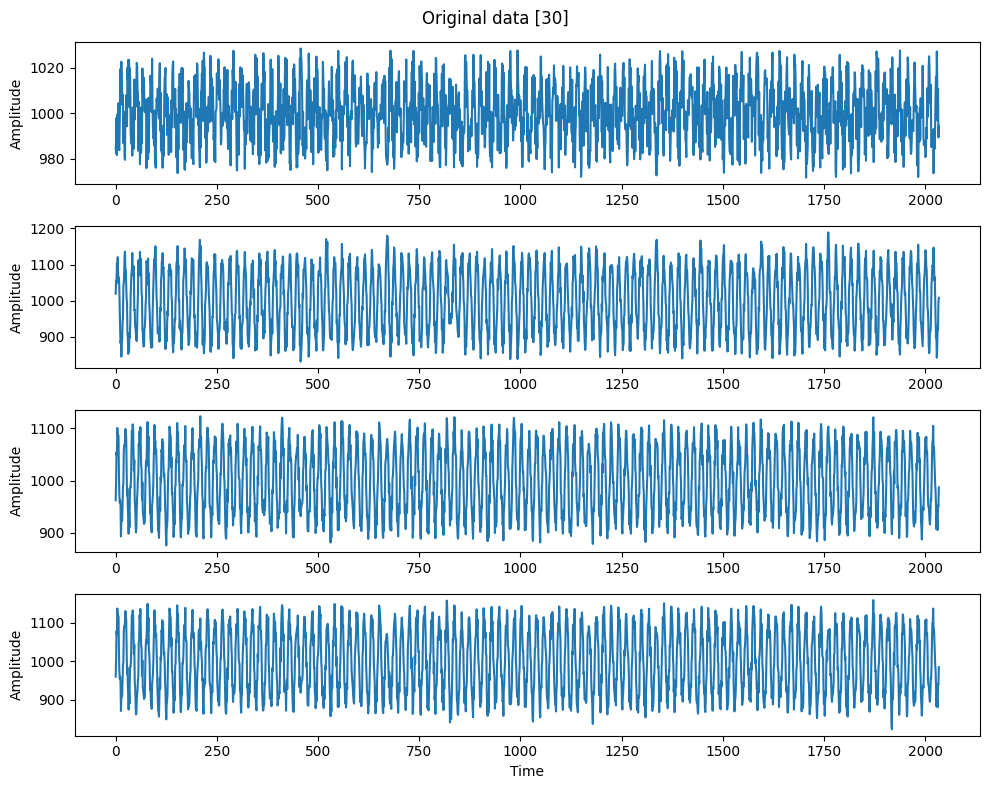

In [244]:
def plot_data_channels(data, suptitle, save=False, fileName=None):
    plt.clf()
    plt.figure(figsize=(10, 2*data.shape[0]))
    plt.suptitle(suptitle)
    for i in range(data.shape[0]):
        plt.subplot(data.shape[0], 1, i + 1)
        plt.plot(data[i])
        if(i == data.shape[0] - 1):
            plt.xlabel("Time")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    if save:
        if fileName is not None:
            plt.savefig(f"{fileName}.png")
        else:
            plt.savefig(f"{i}.png")
        plt.clf()
    else:
        plt.show()

num = 30
plot_data_channels(data_arr[num], f"Original data [{num}]")

In [245]:
def do_ica(data):
    return FastICA(n_components=4).fit_transform(data.T).T

In [246]:
def correct_channel_sign(ica_out):
    for i in range(ica_out.shape[0]):
        if np.abs(np.max(ica_out[i])) < np.abs(np.min(ica_out[i])):
            #print("flipped")
            ica_out[i] *= -1
    return ica_out

In [247]:
def extract_spike_channels(ica_out):
    threshold_counts = []
    for i in range(ica_out.shape[0]):
        threshold_counts.append(np.sum(ica_out[i] >= 1))
        
    spike_channels = []
    min_vals = np.argsort(threshold_counts)[:2]
    for i in min_vals:
        spike_channels.append(ica_out[i])
    return np.array(spike_channels)

In [248]:
from scipy.signal import savgol_filter, find_peaks
# Function to detect peaks using the Pan-Tompkins algorithm
def detect_peaks_pan_tompkins(spike_channels, fs=360, threshold_factor=0.8):
    spiketimes = []
    for signal in spike_channels:
        # 1. Derivative
        derivative = np.diff(signal)

        # 2. Squaring
        squared = derivative ** 2

        # 3. Moving-window integration (using convolution)
        window_size = int(0.15 * fs) # ~54 samples for fs=360
        window = np.ones(window_size) / window_size
        integrated = np.convolve(squared, window, 'same')

        # 4. Thresholding
        threshold = threshold_factor * np.mean(integrated)
        peaks_indices, _ = find_peaks(integrated, height=threshold)
        spiketimes.append(peaks_indices)

    return spiketimes

In [249]:
def detect_peaks_simple(spike_channels, threshold_factor=0.4, distance=40, prominence=2.2, width=(None,30)):
    spiketimes = []
    for signal in spike_channels:
        threshold = np.min(signal) + threshold_factor * np.ptp(signal)
        peaks_indices, _ = find_peaks(signal, height=threshold, distance=distance, prominence=prominence, width=width)
        spiketimes.append(peaks_indices)
    return spiketimes

In [250]:
def plot_data_channels_with_spiketimes(data, suptitle, spiketimes, save=False, fileName=None, ylabels=None):
    plt.clf()
    plt.figure(figsize=(10, 2*data.shape[0]))
    plt.suptitle(suptitle)
    for i in range(data.shape[0]):
        plt.subplot(data.shape[0], 1, i + 1)
        plt.plot(data[i])
        plt.plot(spiketimes[i], data[i][spiketimes[i]], 'x')
        if(i == data.shape[0] - 1):
            plt.xlabel("Time")
        if ylabels is not None:
            plt.ylabel(ylabels[i])
        else:
            plt.ylabel("Amplitude")
    plt.tight_layout()
    if save:
        if fileName is not None:
            plt.savefig(f"{fileName}.png")
        else:
            plt.savefig(f"{i}.png")
        plt.clf()
    else:
        plt.show()

In [251]:
spike_channels_arr = []
spiketimes_arr = []
for i in range(len(data_arr)):#[5,17,35,36,90,128,131]:#
    data_normalized = normalize_all_channels(data_arr[i])

    ica_out = do_ica(data_normalized)
    #plot_data_channels(ica_out, f"ICA out [{i}]")
    ica_corrected = correct_channel_sign(ica_out)
    #plot_data_channels(ica_corrected, f"Sign-Corrected ICA out [{i}]", save=True, fileName=f"ica_images/{i}")
    for channel in range(ica_corrected.shape[0]):
        #ica_corrected[channel] = bandpass_filter(ica_corrected[channel], 0.4, 6, fs=360)
        # spikes are very high frequency, so we must not cut them out and instead use a highpass filter to remove the low frequency noise
        ica_corrected[channel] = highpass_filter(ica_corrected[channel], 0.8, fs=360)
    
    #plot_data_channels(ica_corrected, f"Filtered signals [{i}]")#, save=True, fileName=f"ica_images/{i}")

    spike_channels = extract_spike_channels(ica_corrected)
    #plot_data_channels(spike_channels, f"Heartbeat channels [{i}]", save=True, fileName=f"ica_images/{i}")

    spiketimes = detect_peaks_simple(spike_channels, threshold_factor=0.4, distance=40, prominence=2.2, width=(None,30))
    # sort the channels: [0] - fetal, [1] - maternal
    if len(spiketimes[1]) > len(spiketimes[0]):
        spike_channels = np.array([spike_channels[1], spike_channels[0]])
        spiketimes = [spiketimes[1], spiketimes[0]]
    if i == 46: # cant detect fetus for sample 46, must sort manually
        spike_channels = np.array([spike_channels[1], spike_channels[0]]) 
        spiketimes = [spiketimes[1], spiketimes[0]]
    #plot_data_channels_with_spiketimes(spike_channels, f"Spike Times [{i}]", spiketimes)#, save=True, fileName=f"ica_images/{i}")

    spike_channels_arr.append(spike_channels)
    spiketimes_arr.append(spiketimes)

Explained variance: [0.54360552 0.45639448]


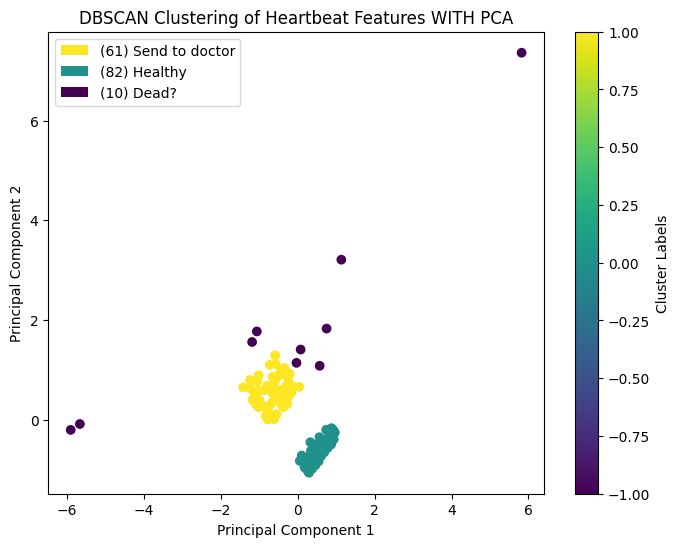

In [255]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from collections import Counter

def get_heartbeat_windows(spike_channels, spiketimes):
    windows_arr = []
    for channel, channeltimes in zip(spike_channels, spiketimes):
        windows = []
        for i in range(len(channeltimes)-2):
            ind1 = (channeltimes[i]+channeltimes[i+1])/2
            ind2 = (channeltimes[i+1]+channeltimes[i+2])/2
            windows.append(channel[int(ind1):int(ind2)])
        windows_arr.append(windows)
    return windows_arr

def get_features(spike_channels_arr, spiketimes_arr):
    features = []
    for spike_channels, spiketimes in zip(spike_channels_arr, spiketimes_arr):
        feature = []
        # spikes/time
        feature.append(len(spiketimes[0])/len(spike_channels[0]))
        #feature.append(len(spiketimes[1])/len(spike_channels[1]))

        # std of distance between spikes
        feature.append(np.std(np.diff(spiketimes[0])))
        #feature.append(np.std(np.diff(spiketimes[1])))

        #feature.append(np.trapz(spike_channels[0][spiketimes[0][0]:spiketimes[0][-1]]))
        
        windows_arr = get_heartbeat_windows(spike_channels, spiketimes)
        for channel_windows in [windows_arr[0]]:
            pass
            #feature.append(np.mean([len(window) for window in channel_windows]))
            #feature.append(np.std([len(window) for window in channel_windows]))
            # area under the curve
            #feature.append(np.mean([np.trapz(window) for window in channel_windows]))
            #feature.append(np.std([np.trapz(window) for window in channel_windows]))

            #feature.append(np.max([np.max(window) for window in channel_windows]))
            #feature.append(np.std([np.max(window) for window in channel_windows]))

            #feature.append(np.min([np.min(window) for window in channel_windows]))
            #feature.append(np.std([np.min(window) for window in channel_windows]))

        features.append(feature)
    return np.array(features)
        
features = get_features(spike_channels_arr, spiketimes_arr)

features = StandardScaler().fit_transform(features)

pca = PCA(n_components=2).fit(features)
pca_result = pca.transform(features)
#pca_result = features
print(f"Explained variance: {pca.explained_variance_ratio_}")

dbscan = DBSCAN(eps=0.25, min_samples=5)
labels = dbscan.fit_predict(pca_result)

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-1, vmax=1)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap=cmap, norm=norm)

unique_labels = np.unique(labels)
label_counts = Counter(labels)

label_to_name = {-1: f"({label_counts[-1]}) Dead?", 0: f"({label_counts[0]}) Healthy", 1: f"({label_counts[1]}) Send to doctor"}
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cmap(norm(label)), label=name)
    for label, name in label_to_name.items()
][::-1]
plt.legend(handles=legend_elements)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering of Heartbeat Features WITH PCA")
plt.colorbar(label='Cluster Labels')
plt.show()

Cluster -1: [134  99  67  97 131  36 138 139  46  10]


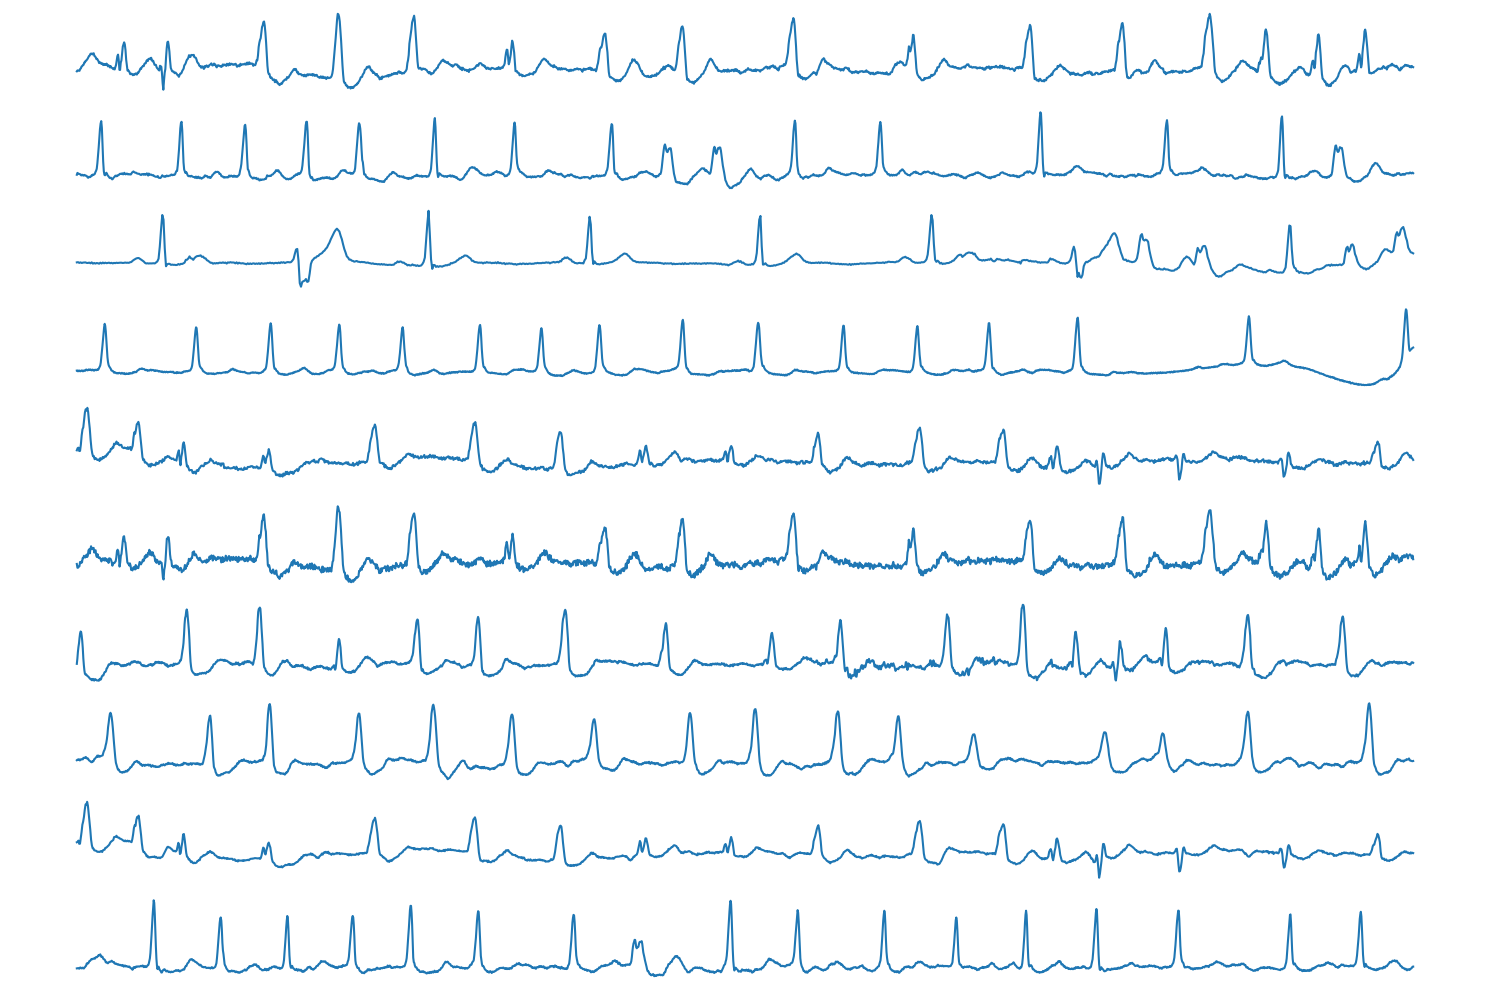

Cluster 0: [ 57 126  29   8 105 147 101  63   9 150]


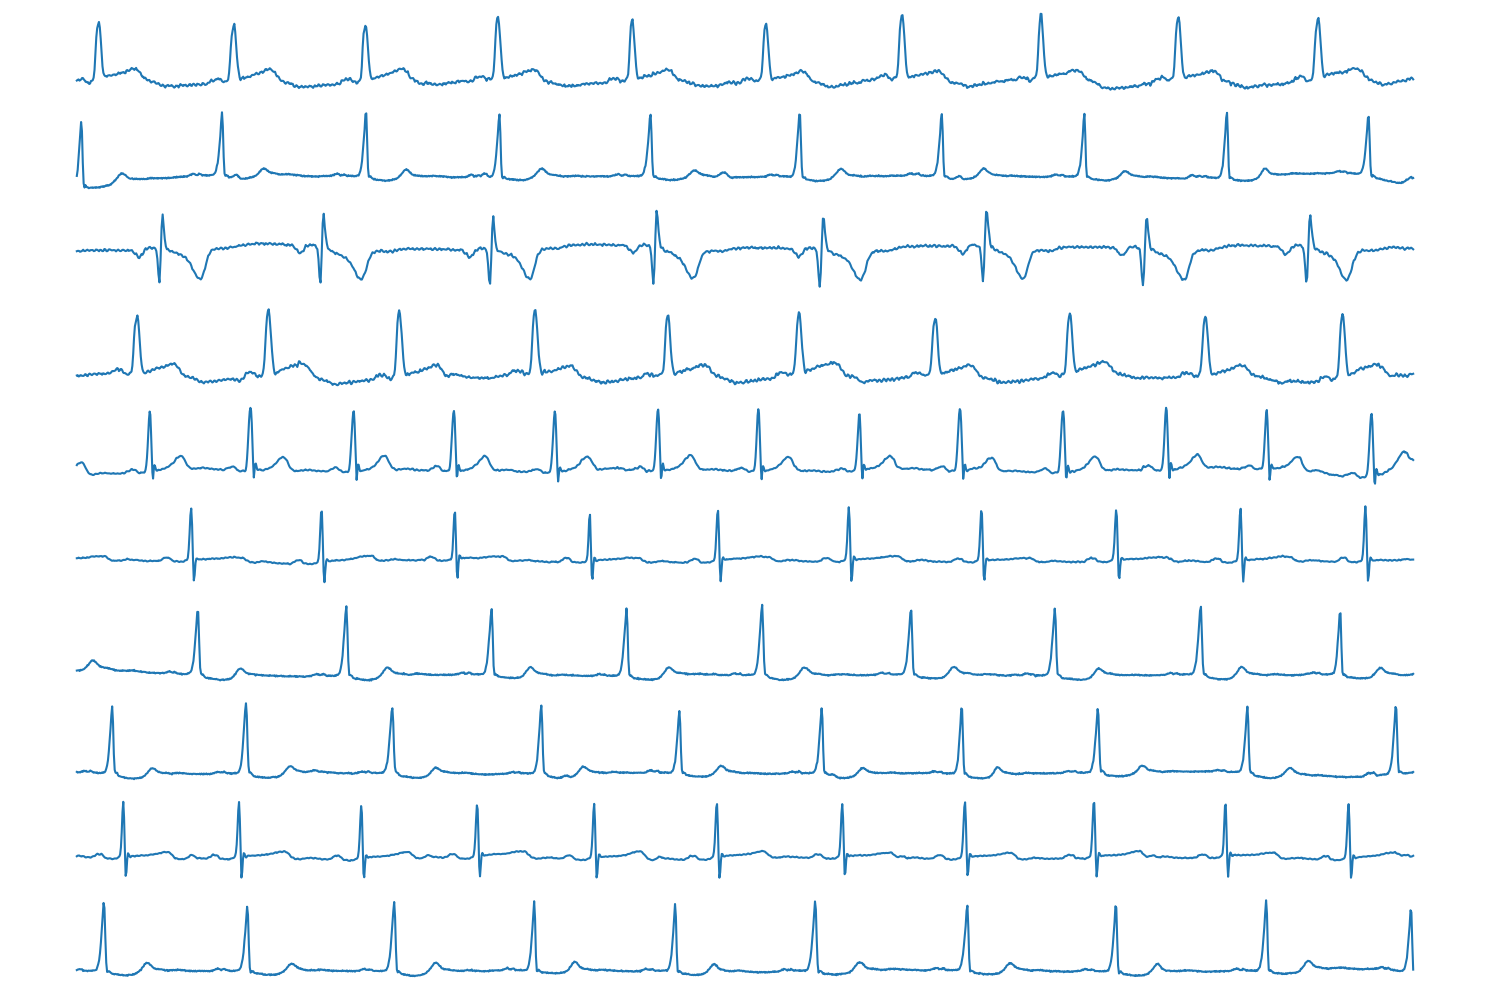

Cluster 1: [ 12  15  33  48  21 103  58 142  87 145]


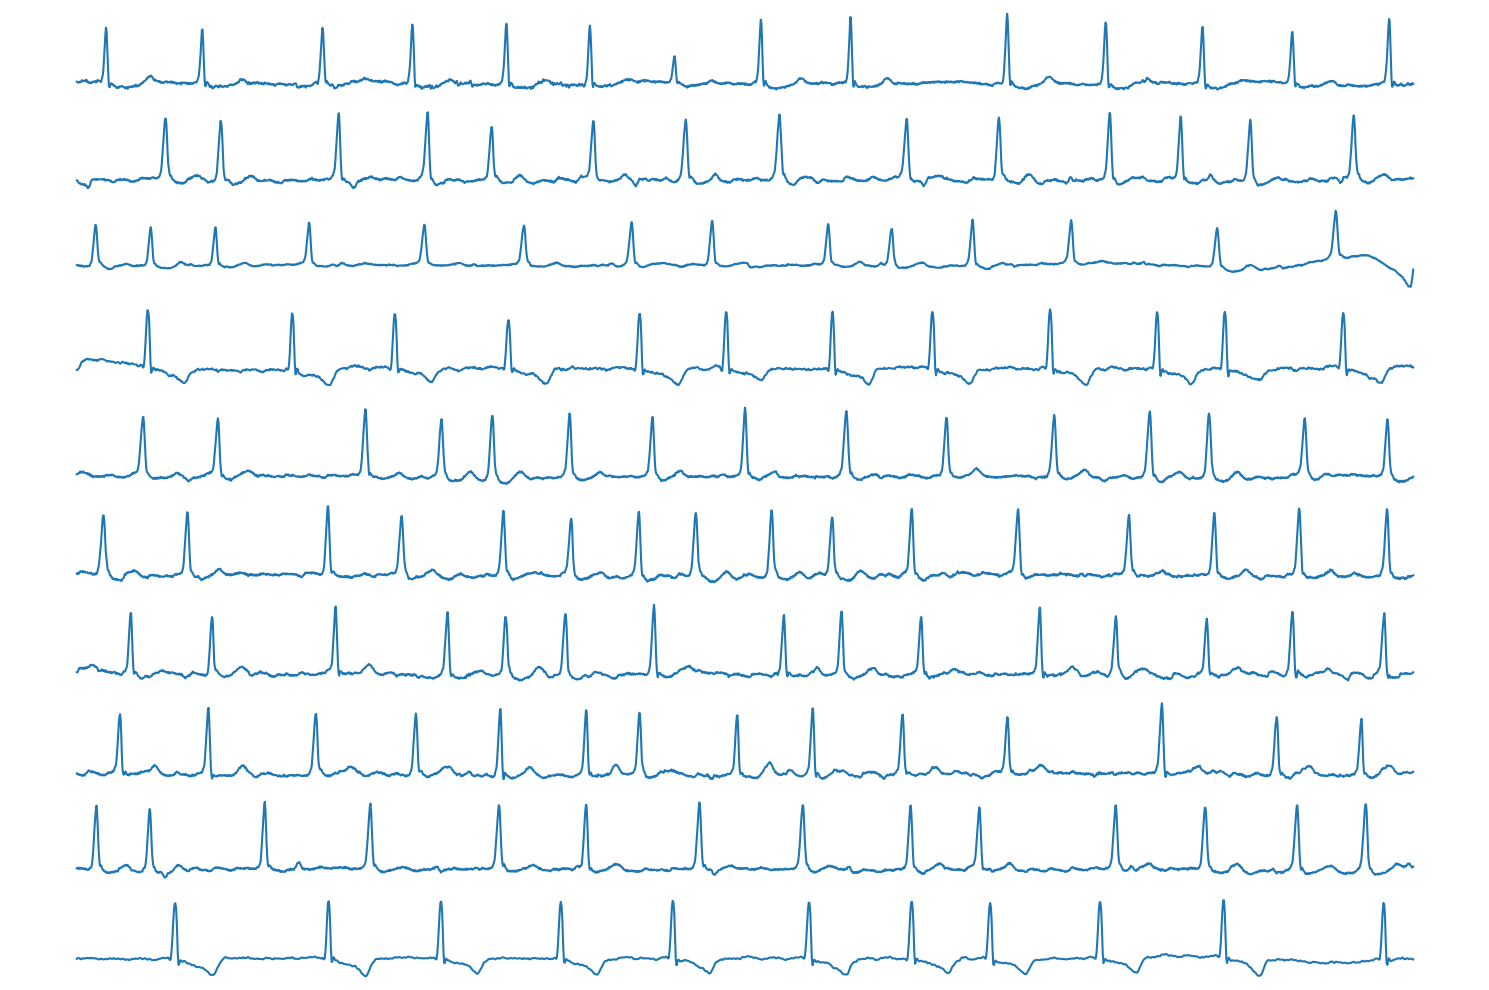

In [253]:
# Plot ten representative heartbeats from each cluster
from collections import Counter

num_representatives = 10

for cluster in unique_labels:
    cluster_indices = np.where(labels == cluster)[0]
    selected_indices = np.random.choice(cluster_indices, num_representatives, replace=False)
    print(f"Cluster {cluster}: {selected_indices}")
    plt.figure(figsize=(15, 1*num_representatives))
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(num_representatives, 1, i + 1)
        plt.plot(spike_channels_arr[idx][0])
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.axis('off')
    plt.tight_layout()
    #plt.suptitle(f'Representative Heartbeats from Cluster {cluster}')
    #plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()